# makemore: part 3

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# randn gives guassian distribution with mean 0 and std 1
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd * block_size)**0.5 # * 0.2  (this multiply was general)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
# (5/3) / (n_embd * block_size)**0.5  -> this term is kaiming initialization formula -> std = gain / sqrt(fan_in) see pytorch init docs

# We want our hidden layer output to be close to zero for tanh activation to prevent vanishing gradient
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Dont make Weights 0 at start 
b2 = torch.randn(vocab_size,                      generator=g) * 0 

# Batch normalization parameters
bngain = torch.ones((1,n_hidden)) # gain for batch normalization or gamma
bnbias = torch.zeros((1,n_hidden)) # bias for batch normalization or beta

# for inference of batch normalization
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running  = torch.ones((1,n_hidden))

parameters = [C, W1,b1, W2, b2,bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation 
  
  # bias of hidden layer have no effect (b1.grad = 0) when batch normazlization so thats why we do bias = False in pytorch
  
  # applying batch normalization
  bnmeani = hpreact.mean(dim=0,keepdim=True) # mean for that batch
  bnstdi = hpreact.std(dim=0,keepdim=True)  # std for that batch
  
  hpreact = bngain * (hpreact - bnmeani) / (bnstdi) + bnbias # batch normalization
  
  with torch.no_grad(): # calculating this for inference for batch normalization
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
  # Non linearity 
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [38]:
# import numpy as np

# # Vanishing gradient problem visualization as if x is large/small tan(x) is close to 1/-1 which causes gradient of tanh to be close to 0
# # and thus blocking the gradient flow when back propagating through the network.
# x = np.linspace(-10, 10, 1000)
# tanh = (np.exp(2*x) - 1)/(np.exp(2*x) + 1)
# grad = 1 - tanh**2

# plt.plot(x, tanh, label='tanh(x)')
# plt.plot(x, grad, label="tanh'(x)", linestyle='--')
# plt.legend()
# plt.grid()
# plt.title("tanh and its derivative")
# plt.show()



In [39]:
# plt.figure(figsize=(20, 10))
# plt.imshow(h.abs() > 0.99, cmap='gray',interpolation='nearest')
# # Black means the neuron is false, white means true condition.

In [40]:
# plt.hist(h.view(-1).tolist(), bins=50)
# # to see values of tanh activation function that its in tails or not 

In [9]:
# 0/ 200000: 27.8817  , Initial loss is way too high the model is wrong confident and at initial the logits should be close to 0
# so that softmax assign equal probabilities to all characters at start that reduces the loss at beggining 

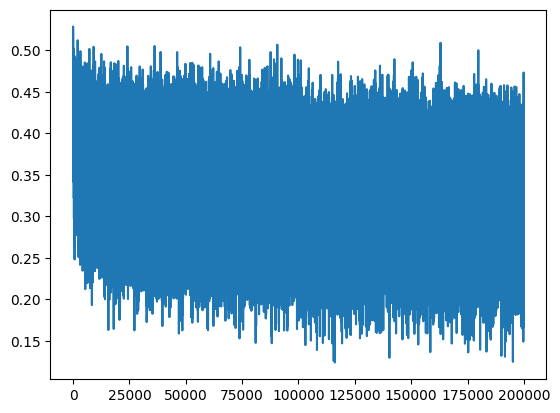

In [23]:
plt.plot(lossi)

In [ ]:
# with torch.no_grad():
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0],-1)
#     hpreact = embcat @ W1 + b1
#     # calculating average mean and std on training to use in inference as we will dont have whole batch mean and std
#     bnmean = hpreact.mean(axis=0,keepdim=True)
#     bnstd = hpreact.std(axis=0,keepdim=True)

# #No need for again running loop to calculate mean and bias , instead we can keep track of it while running 

In [28]:
# No need for bias in layer when batch normalization is after it

In [29]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 #+ b1
  hpreact = bngain * ((hpreact - bnmean_running) / (bnstd_running)) + bnbias # batch normalization
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

# from train 2.12 and val 2.16  to ---> train 2.035 and val 2.102 by fixing 2 issues 

train 2.0666232109069824
val 2.105177402496338


In [30]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = emb.view(1, -1) @ W1 #+b1
      h = bngain * ((h - bnmean_running) / (bnstd_running)) + bnbias
      h = torch.tanh(h)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
mad.
ryla.
reimastengraeg.
adelyn.
elin.
shi.
jen.
eden.
sana.
arleigh.
malaia.
noshubergahimie.
tri.
joselle.
jose.
casubelledi.
jamyleyeh.


In [42]:
# 1) At initialization, make bias to be 0 and weights to be small not zero . The reason is that model cant be too confident at the start of training and due to softmax it dont assign some wrong class
# 2) If tanh activation is used, make sure that the weights are small enough so that the pre-activation values are not too large or too small. This prevents vanishing gradient problem. Values of pre-activation should be in range [-1, 1] to prevent saturation of tanh activation function and not in tails of -1 and 1.
# 3) Use Kaiming initialization to set the weights of the hidden layer to be small enough so that the pre-activation values are not too large or too small. This prevents vanishing gradient problem.
# 4) Batch Normalization ( But try to avoid )

Mean: 0.00, Std: 0.77


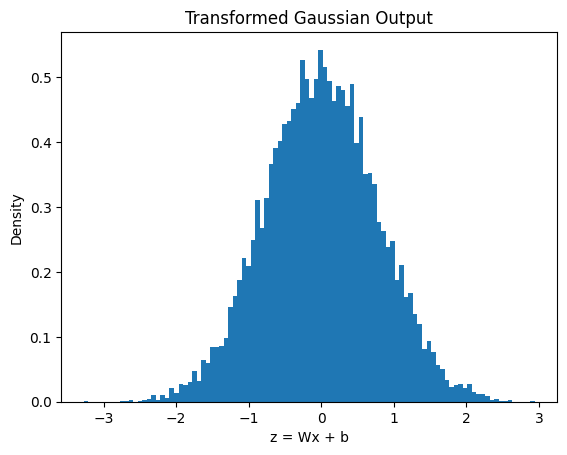

In [ ]:
# import torch
# import matplotlib.pyplot as plt

# x = torch.randn(10000, 10)  # Gaussian input
# W = torch.randn(10, 1) / 10**0.5  # scale weights by sqrt(input coming) to make output guassian distributed
# b = torch.tensor([0.0])     # Bias → mean shift

# z = x @ W + b

# print(f"Mean: {z.mean().item():.2f}, Std: {z.std().item():.2f}")

# plt.hist(z.numpy(), bins=100, density=True)
# plt.title("Transformed Gaussian Output")
# plt.xlabel("z = Wx + b")
# plt.ylabel("Density")
# plt.show()


In [52]:
# Rewrite the model as in pytorch 

In [66]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
# layers = [
#   Linear(n_embd * block_size, n_hidden, bias=False),Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False),Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False),Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False),Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False),Tanh(),
#   Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]
layers = [
   Linear(n_embd * block_size, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, vocab_size),
 ]

with torch.no_grad():
  # last layer: make less confident
  #layers[-1].gamma *= 0.1
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 #1.0 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [79]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.01 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.0098


layer 1 (      Tanh): mean -0.05, std 0.77, saturated: 22.69%
layer 3 (      Tanh): mean -0.02, std 0.73, saturated: 12.91%
layer 5 (      Tanh): mean -0.00, std 0.76, saturated: 16.94%
layer 7 (      Tanh): mean -0.05, std 0.77, saturated: 15.38%
layer 9 (      Tanh): mean +0.01, std 0.72, saturated: 12.41%


Text(0.5, 1.0, 'activation distribution')

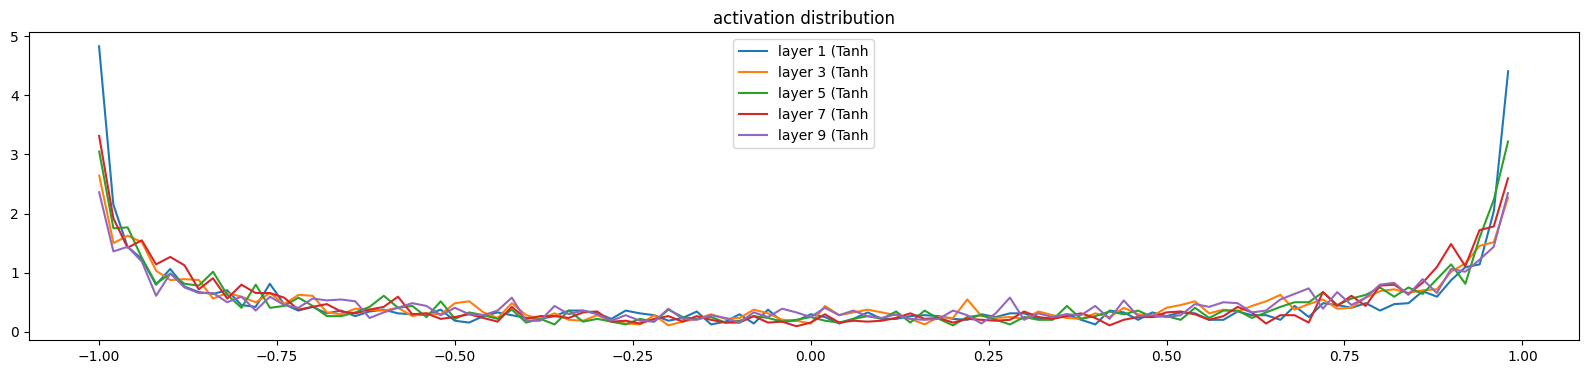

In [80]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.000008, std 2.938510e-03
layer 3 (      Tanh): mean -0.000068, std 2.992191e-03
layer 5 (      Tanh): mean -0.000052, std 2.932813e-03
layer 7 (      Tanh): mean -0.000075, std 2.929902e-03
layer 9 (      Tanh): mean -0.000058, std 2.547518e-03


Text(0.5, 1.0, 'gradient distribution')

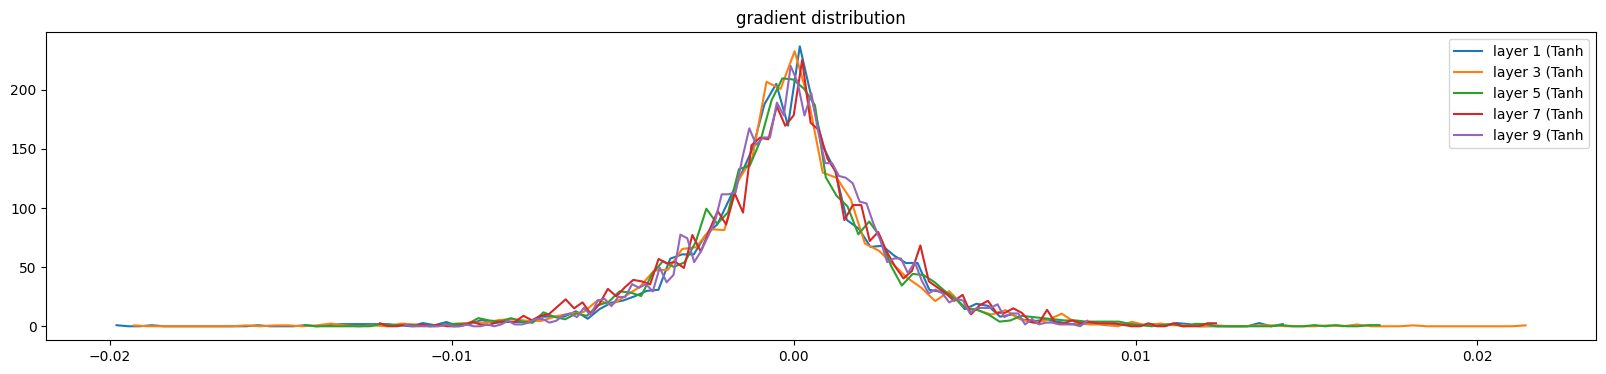

In [81]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000225 | std 1.043834e-02 | grad:data ratio 1.040595e-02
weight  (30, 100) | mean -0.000163 | std 9.939012e-03 | grad:data ratio 3.154818e-02
weight (100, 100) | mean +0.000092 | std 7.505041e-03 | grad:data ratio 4.396541e-02
weight (100, 100) | mean -0.000048 | std 6.775038e-03 | grad:data ratio 3.947110e-02
weight (100, 100) | mean +0.000030 | std 6.825380e-03 | grad:data ratio 3.995327e-02
weight (100, 100) | mean +0.000117 | std 6.658733e-03 | grad:data ratio 3.933814e-02
weight  (100, 27) | mean -0.000000 | std 2.221709e-02 | grad:data ratio 2.626200e-01


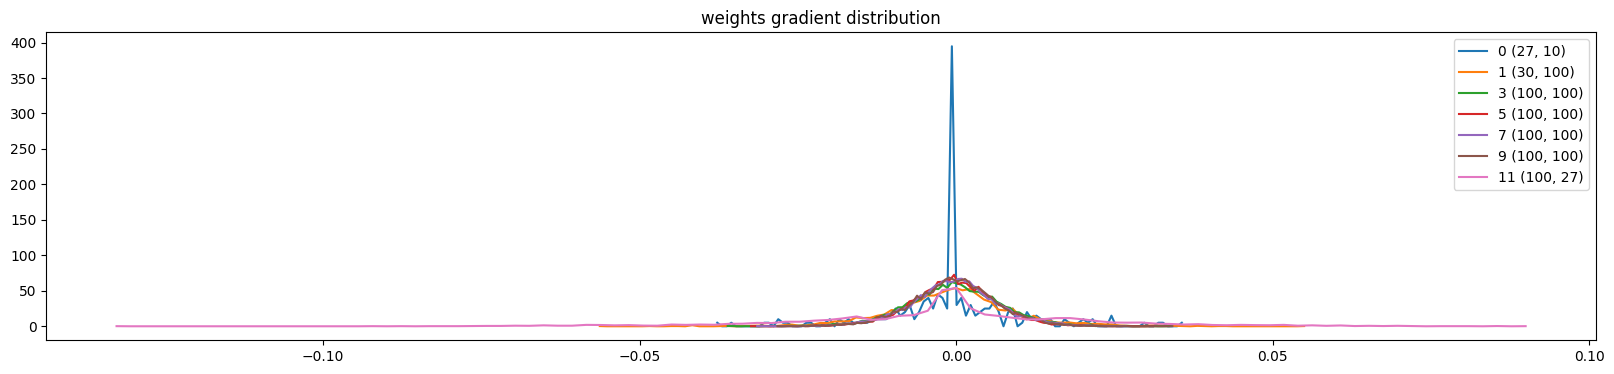

In [82]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

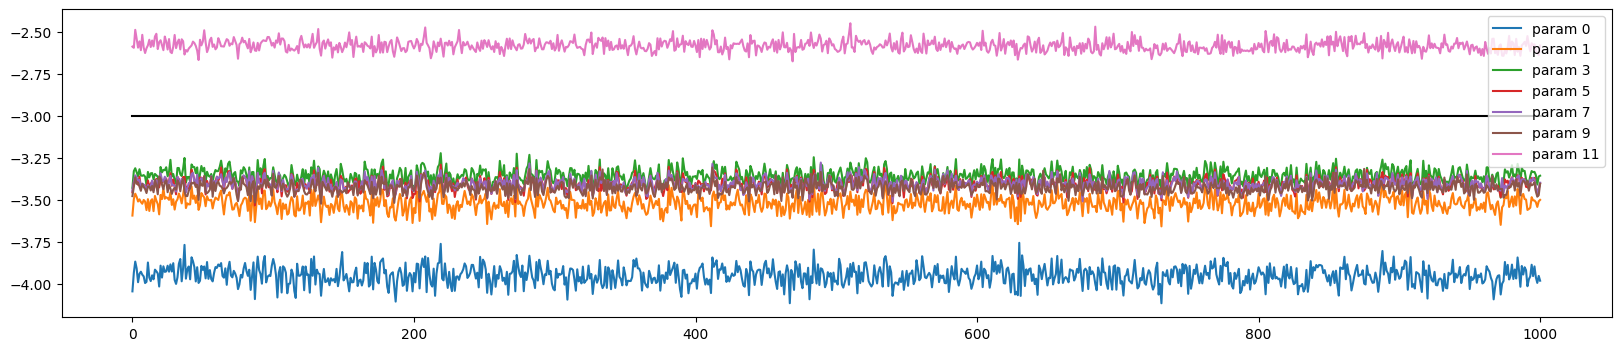

In [83]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);